# CENG 483 THE 2

**Name:** Atakan Gelecek

**Student ID:** 2521599



In [1]:
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import uniform_filter, gaussian_filter
import time


In [2]:
# take images
image_name_list = ['chessboard.png', 'chessboard-rotated.png', 'lab.png','lab-rotated.png', 'tree.png', 'tree-rotated.png']
def take_images():
    image_list = []
    for image_name in image_name_list:    
        image = cv2.imread("images/" +image_name, cv2.IMREAD_GRAYSCALE)
        image_list.append(image)
    
    return image_list

def take_images_color():
    image_list = []
    for image_name in image_name_list:    
        image = cv2.imread("images/" +image_name, cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image_rgb)
    
    return image_list

def gradient_x(image):
    # compute the x-gradient of the image
    filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    # Cast the image to double to prevent overflows occurred in the determinant calculation
    return convolve2d(image.astype(np.double), filter, mode='same')

def gradient_y(image):
    # compute the y-gradient of the image
    filter = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    # Cast the image to double to prevent overflows occurred in the determinant calculation
    return convolve2d(image.astype(np.double), filter, mode='same')

def non_maximum_suppression(corner_strength_coords, corner_values, shape, neighborhood_size):
    # create a corner strength list that contains the corner strength values of the pixels in the image
    corner_strength_list = np.zeros(shape)
    for i in range(len(corner_strength_coords)):
        corner_strength_list[corner_strength_coords[i][0], corner_strength_coords[i][1]] = corner_values[i]
    
    max_corners = []
    max_values = []

    for i in range(len(corner_strength_coords)):
        # get neighborhood
        y_min = max(0, corner_strength_coords[i][0]-neighborhood_size//2)
        y_max = min(shape[0], corner_strength_coords[i][0]+neighborhood_size//2)
        x_min = max(0, corner_strength_coords[i][1]-neighborhood_size//2)
        x_max = min(shape[1], corner_strength_coords[i][1]+neighborhood_size//2)
        neighborhood = corner_strength_list[y_min:y_max, x_min:x_max]
        
        #find the maximum value's index in the neighborhood
        max_idx = np.argmax(neighborhood)
        # Convert this index to 2D coordinates
        max_idx_2d = np.unravel_index(max_idx, neighborhood.shape)
        # Adjust the coordinates relative to the entire image
        max_y, max_x = max_idx_2d[0] + y_min, max_idx_2d[1] + x_min
        
        # if the maximum value is the corner that we are traversing, append its coordinates and value to the lists
        if (corner_strength_list[corner_strength_coords[i][0], corner_strength_coords[i][1]] == np.max(neighborhood) and corner_strength_coords[i][0] == max_y and corner_strength_coords[i][1] == max_x ):
            max_corners.append(corner_strength_coords[i])
            max_values.append(corner_values[i])
    
    return max_corners, max_values

def non_maximum_suppression_rgb(corner_strengths, neighborhood_size):
    height, width = corner_strengths.shape
    suppressed_strengths = np.zeros_like(corner_strengths)
    max_corners = []
    max_values = []

    for y in range(height):
        for x in range(width):
            # Skip already detected points
            if suppressed_strengths[y, x] > 0:
                continue
            
            # Define the neighborhood
            y_min = max(0, y - neighborhood_size // 2)
            y_max = min(height, y + neighborhood_size // 2 + 1)
            x_min = max(0, x - neighborhood_size // 2)
            x_max = min(width, x + neighborhood_size // 2 + 1)

            # Get neighborhood
            neighborhood = corner_strengths[y_min:y_max, x_min:x_max]

            # Find the local maximum
            local_max = neighborhood.max()

            # If the current pixel is the local max and not already suppressed
            if corner_strengths[y, x] == local_max and local_max > 0:
                # Mark the local max
                suppressed_strengths[y, x] = local_max
                max_corners.append((y, x))
                max_values.append(local_max)

                # Suppress the neighborhood
                suppressed_strengths[y_min:y_max, x_min:x_max] = 0
                # Make sure to mark the current max again, as it became zero by the line above
                suppressed_strengths[y, x] = local_max

    return max_corners, max_values

def corner_plotter(img, coordinates):
  figure, ax = plt.subplots()
  # Display the image
  ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
  for coordinate in coordinates:
    # Plot the coordinates with a red x
    ax.plot(coordinate[1], coordinate[0], 'x', color='red', markersize=15)

## Naive Formula + Uniform Weighting (without Non-Maximum Suppression)

Average time to process one image: 3.213435411453247 seconds


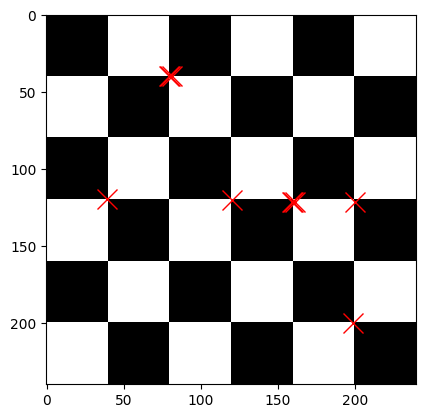

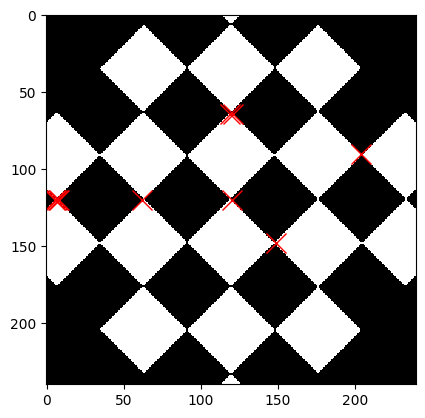

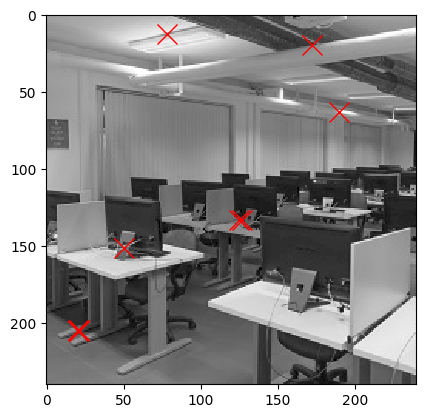

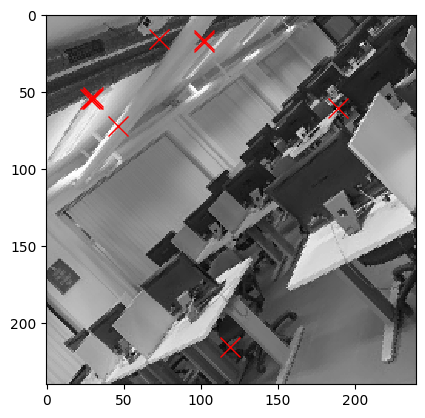

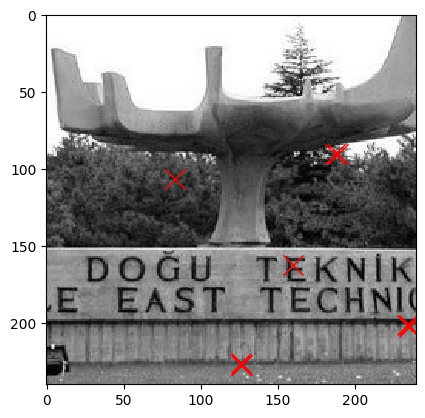

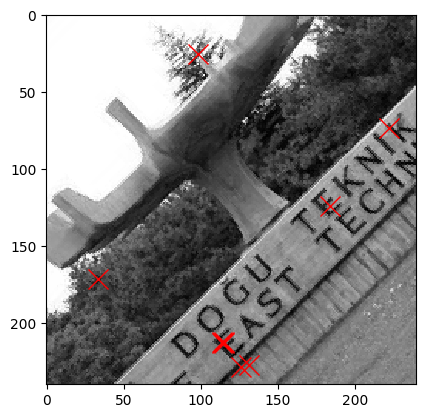

In [3]:
U = 3
V = 3
# boundary variable was used to eliminate the artificial high responses originating from image boundaries rather than corners
boundary = 4
window_size = 4

def naive_formula(image, boundary, window_size, u, v):
    corners = []
    distances = []
    # u v direction combinations
    combinations = [(-u, -v), (-u, 0), (-u, v), (0, -v), (0, v), (u, -v), (u, 0), (u, v)]
    height = image.shape[0]
    width = image.shape[1]

    for y in range(boundary, height-boundary+1):
        for x in range(boundary, width-boundary+1):
            summation = 0
            for u, v in combinations:
                # create windows
                original_window = image[y-window_size//2: y+window_size//2, x-window_size//2: x+window_size//2]
                shifted_window = image[y-window_size//2 + v: y+window_size//2 + v, x-window_size//2 + u: x+window_size//2 + u]
                    
                # on boundaries ignore
                if (original_window.shape != shifted_window.shape):
                    continue
                
                # calculate squared distance
                summation += (np.sum((original_window-shifted_window)**2))
            
            # append corner and distance
            corners.append([y,x])
            distances.append(summation)
    return corners, distances

images = take_images()

total_time = 0
for image in images:
    start_time = time.time()

    corner_strength_coords, distances = naive_formula(image, boundary, window_size, U, V)
    corner_strength_coords = np.array(corner_strength_coords)
    distances = np.array(distances)
    
    # get the top 10 corners' indexes
    top_10_indexes = np.argpartition(distances, -10)[-10:]
    # get the top 10 corners' coordinates 
    top_10_corners = []
    for i in range(len(top_10_indexes)):
        top_10_corners.append(corner_strength_coords[top_10_indexes[i]])
    corner_plotter(image, np.array(top_10_corners))
    
    processing_time = time.time() - start_time  # Time taken to process the image
    total_time += processing_time  # Accumulate the time for each image

print("Average time to process one image:", total_time/len(images) , "seconds")
    
    


### Discussion

- The overall runtime is slow compared to more efficient implementations, approximately 20 seconds in total. This is due to the simplistic approach of iterating through each window, leading to a much higher time complexity compared to more efficient techniques.

- Additionally, there is a significant issue with overlapping in the detected corners of the images. This occurs mainly because non-maximum suppression is not applied to the corners. As a result, regions with stronger responses in the close regions dominates the top 10 corner responses.



## Naive Formula + Uniform Weighting

Average time to process one image: 3.9132900635401406 seconds


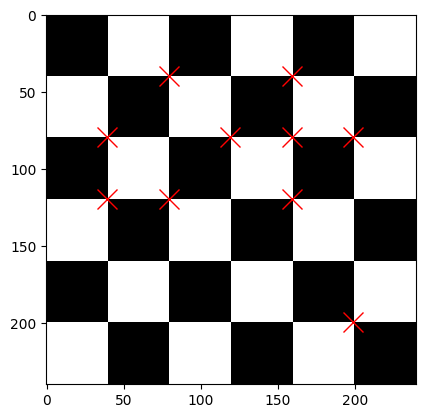

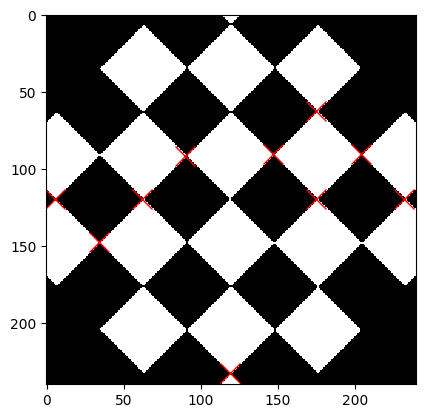

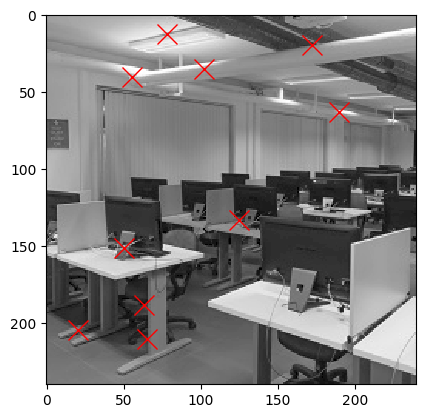

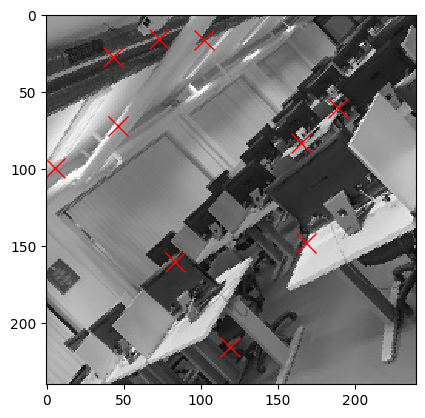

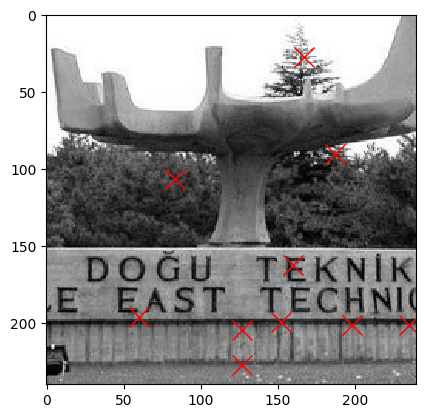

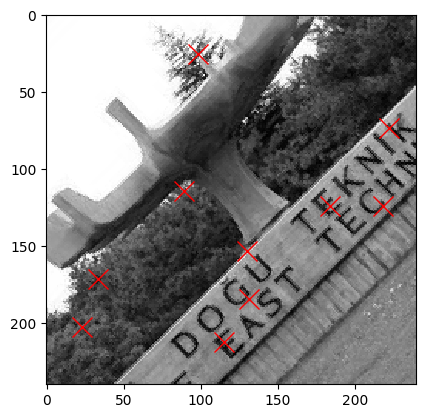

In [4]:
U = 3
V = 3
window_size = 4
# boundary variable was used to eliminate the artificial high responses originating from image boundaries rather than corners
boundary = 4
neighborhood_size = 40


images = take_images()
total_time = 0
for image in images:
    start_time = time.time()
    
    corner_strength_coords, distances = naive_formula(image, boundary, window_size, U, V)
    max_corners, max_distances = non_maximum_suppression(corner_strength_coords, distances, image.shape, neighborhood_size)
    max_corners = np.array(max_corners)
    max_distances = np.array(max_distances)

    # get the top 10 corners' indexes
    top_10_indexes = max_distances.argpartition(-10)[-10:]
    # get the top 10 corners' coordinates
    top_10_corners = []
    for i in range(len(top_10_indexes)):
        top_10_corners.append(max_corners[top_10_indexes[i]])

    corner_plotter(image, np.array(top_10_corners))
    
    processing_time = time.time() - start_time  # Time taken to process the image
    total_time += processing_time  # Accumulate the time for each image

print("Average time to process one image:", total_time/len(images) , "seconds")
    
    


### Discussion
- The overall runtime is around 23 seconds, increased compared to the previous case. This occurs because in this case, we are also applying non-maximum suppression to each of the image, which resulting with a higher time complexity.

- Since we applied non-maximum suppression to each image, we now able to capture more distinct corners well-distributed throughout the images.

## Taylor's Approximation + Uniform Weighting

Average time to process one image: 2.8702386617660522 seconds


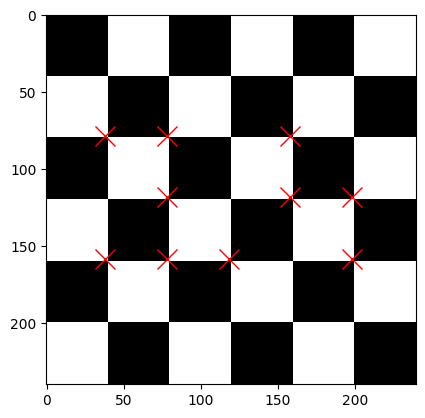

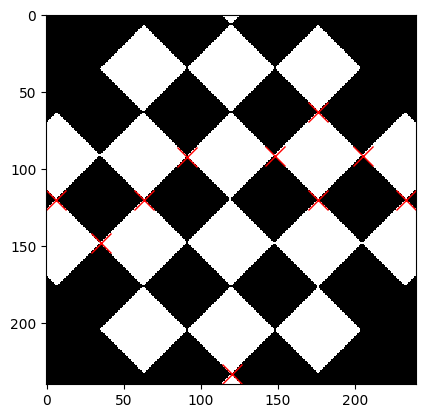

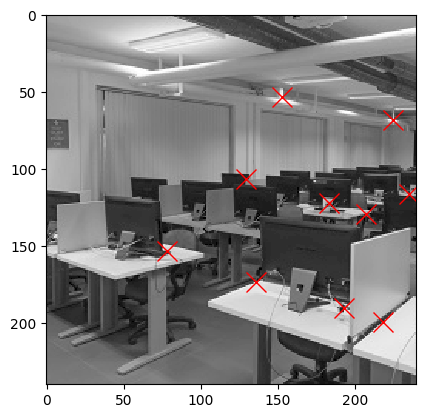

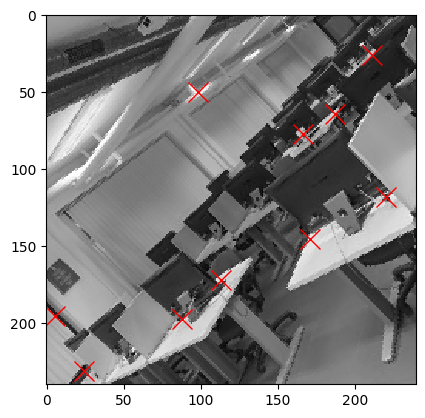

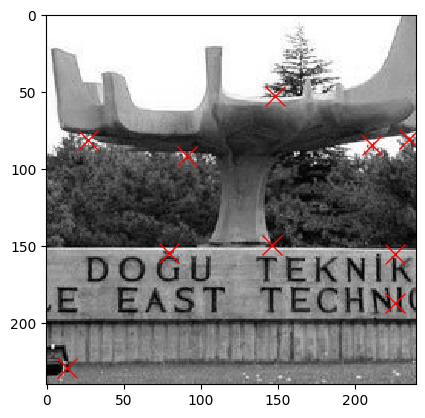

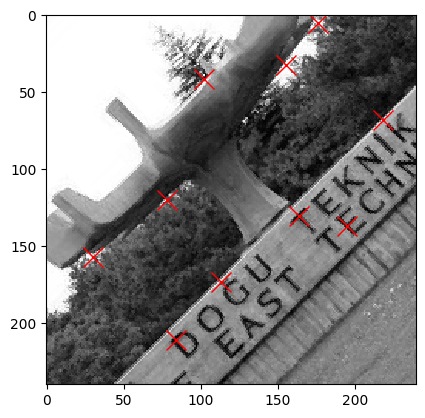

In [5]:
u = 3
v = 3
window_size = 4
# boundary variable was used to eliminate the artificial high responses originating from image boundaries rather than corners
boundary = 5
neighborhood_size = 40

def taylors_approximation(image):
    Ix = gradient_x(image)
    Iy = gradient_y(image)
    Ix_squared = uniform_filter(Ix**2)
    Iy_squared = uniform_filter(Iy**2)
    IxIy = uniform_filter(Ix*Iy)
    
    # coordinates and strength of corners
    corner_strength_coords = []
    corner_strength_values = []

    # u v direction combinations
    combinations = [(-u, -v), (-u, 0), (-u, v), (0, -v), (0, v), (u, -v), (u, 0), (u, v)]
    height = image.shape[0]
    width = image.shape[1]

    for y in range(boundary, height-boundary+1):
        for x in range(boundary, width-boundary+1):
            summation = 0

            # create window and calculate matrix
            Sxx = Ix_squared[y - window_size: y + window_size, x - window_size: x + window_size].sum()
            Syy = Iy_squared[y - window_size: y + window_size, x - window_size: x + window_size].sum()
            Sxy = IxIy[y - window_size: y + window_size, x - window_size: x + window_size].sum()
            matrix = np.array([[Sxx, Sxy], [Sxy, Syy]])

            # for each combination calculate the corner strength and sum them
            for u_comb, v_comb in combinations:
                vector = np.array([u_comb,v_comb])
                result = np.dot(np.transpose(vector),(np.dot(matrix, vector)))    
                summation += result

                
            corner_strength_coords.append([y,x])
            corner_strength_values.append(summation)
    
    corner_strength_coords = np.array(corner_strength_coords)
    corner_strength_values = np.array(corner_strength_values)
    return corner_strength_coords, corner_strength_values

images = take_images()
total_time = 0
for image in images:
    start_time = time.time()

    corner_strength_coordinates, corner_strength_vals = taylors_approximation(image)
    max_corners_taylor, max_values = non_maximum_suppression(corner_strength_coordinates, corner_strength_vals, image.shape, neighborhood_size)
    max_corners_taylor = np.array(max_corners_taylor)
    max_values = np.array(max_values)
    
    # get the top 10 corners' indexes
    top_10_indexes = max_values.argpartition(-10)[-10:]

    # get the top 10 corners' coordinates
    top_10_corners = []
    for i in range(len(top_10_indexes)):
        top_10_corners.append(max_corners_taylor[top_10_indexes[i]])
    
    corner_plotter(image, np.array(top_10_corners))

    processing_time = time.time() - start_time  # Time taken to process the image
    total_time += processing_time  # Accumulate the time for each image

print("Average time to process one image:", total_time/len(images) , "seconds")
        


### Discussion
- The overall runtime is around 18 seconds, which improves compared to the naive implementations. This runtime improvement is expected as we are using Taylor series approximation instead of sum of squared differences of pixels.

- The method we are using effectively captures corners that are well-distributed across the key interest points in the images. This approach is an approximation to a naive method also with non-maximum suppression.

## Fast Implementation + Uniform Weighting

Average time to process one image: 0.6848768393198649 seconds


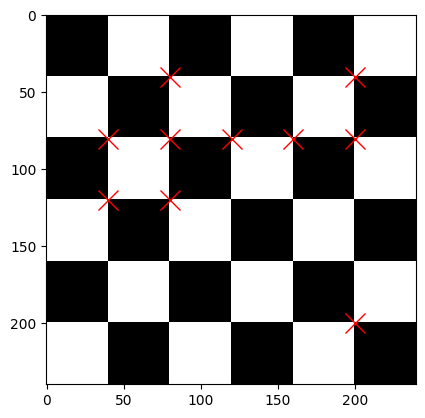

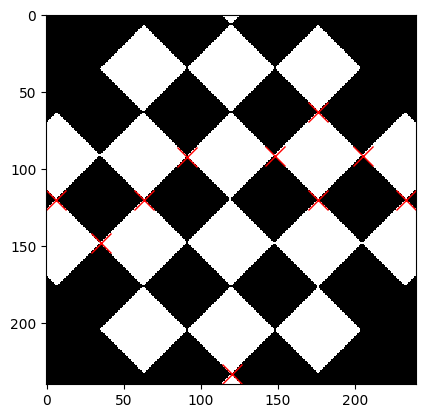

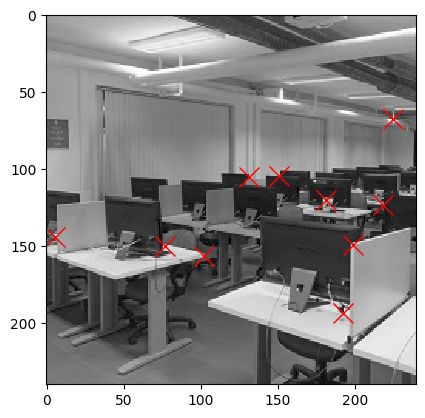

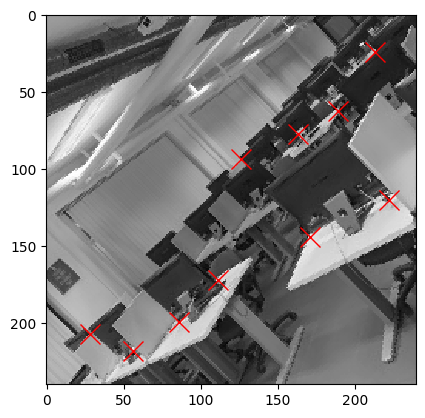

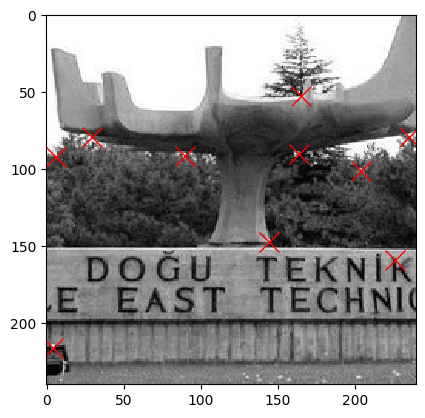

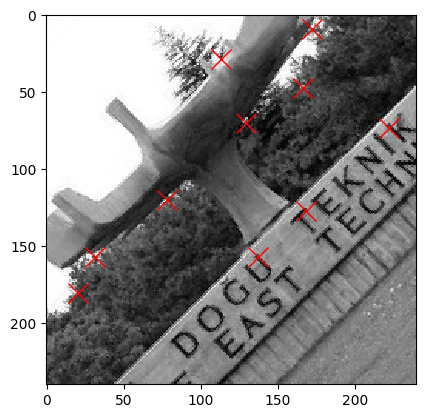

In [6]:
k = 0.05
neighborhood_size = 40
# boundary variable was used to eliminate the artificial high responses originating from image boundaries rather than corners
boundary = 4
window_size = 2

def fast_harris(image, boundary, window_size):
    # compute Ix, Iy, Ix_squared, Iy_squared, IxIy for the entire image
    Ix = gradient_x(image)
    Iy = gradient_y(image)
    Ix_squared = uniform_filter(Ix**2)
    Iy_squared = uniform_filter(Iy**2)
    IxIy = uniform_filter(Ix*Iy)
    
    height = image.shape[0]
    width = image.shape[1]    

    # coordinates and strength of corners
    corner_strength_coords = []
    corner_strength_values = []

    for y in range(boundary, height-boundary+1):
        for x in range(boundary, width-boundary+1):
            # create windows and calculate Ix^2, Iy^2, IxIy sums
            Ixx_sum = (Ix_squared[y-(window_size//2): y+(window_size//2), x-(window_size//2): x+(window_size//2)]).sum()
            Iyy_sum = (Iy_squared[y-(window_size//2): y+(window_size//2), x-(window_size//2): x+(window_size//2)]).sum()
            Ixy_sum = (IxIy[y-(window_size//2): y+(window_size//2), x-(window_size//2): x+(window_size//2)]).sum()
            
            # calculate corner strength
            determinant = Ixx_sum * Iyy_sum - Ixy_sum * Ixy_sum
            trace = Ixx_sum + Iyy_sum
            corner_strength = determinant - k * (trace**2)
            
            if (corner_strength > 0):
                corner_strength_coords.append([y, x])
                corner_strength_values.append(corner_strength)
                
    return corner_strength_coords, corner_strength_values

images = take_images()
total_time = 0
for image in images:
    start_time = time.time()
    
    corner_strength_coords, corner_strength_values = fast_harris(image, boundary, window_size)
    max_corners_fast, max_values = non_maximum_suppression(corner_strength_coords, corner_strength_values, image.shape, neighborhood_size)
    max_corners_fast = np.array(max_corners_fast)
    max_values = np.array(max_values)

    # get the top 10 corners' indexes
    top_10_indexes = max_values.argpartition(-10)[-10:]
    
    # get top_10 corners' coordinates 
    top_10_corners = []
    for i in range(len(top_10_indexes)):
        top_10_corners.append(max_corners_fast[top_10_indexes[i]])
    corner_plotter(image, np.array(top_10_corners))
    
    processing_time = time.time() - start_time  # Time taken to process the image
    total_time += processing_time  # Accumulate the time for each image

print("Average time to process one image:", total_time/len(images) , "seconds")

### Discussion
- The overall runtime is approximately 4.8 seconds, significantly improved compared to previous implementations. The value of k has been selected as 0.05, following the recommendation from the lecture slides, which suggest a range between 0.04 and 0.06. 

- We are also effectively capturing corners that are well-distributed across the key interest points in the images. Also according to my observation, there is an increase in the accuracy of the detecting corners correctly, specifically in lab images and tree images, compared to previous versions.

## Fast Implementation + Circular Weighting

Average time to process one image: 0.5998664697011312 seconds


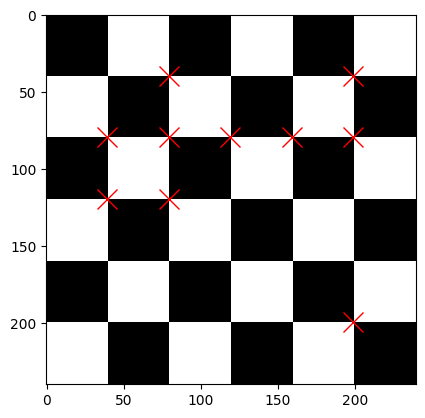

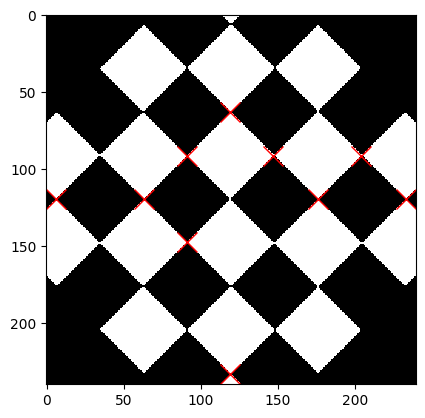

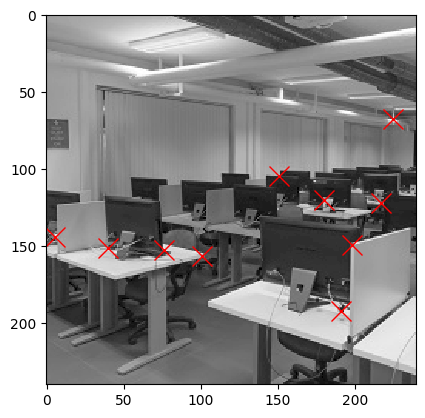

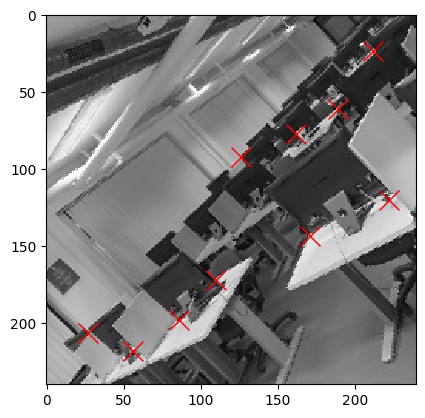

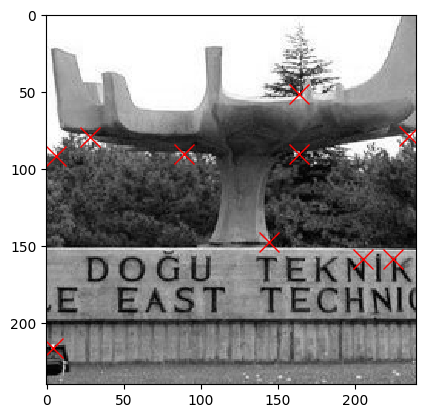

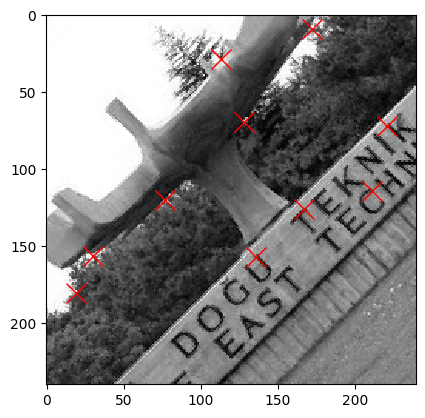

In [7]:
k = 0.05
neighborhood_size = 40
# boundary variable was used to eliminate the artificial high responses originating from image boundaries rather than corners
boundary = 4
window_size = 3

def fast_harris_circular(image, boundary, window_size):
    # compute Ix, Iy, Ix_squared, Iy_squared, IxIy for the entire image
    Ix = gradient_x(image)
    Iy = gradient_y(image)
    Ix_squared = uniform_filter(Ix**2)
    Iy_squared = uniform_filter(Iy**2)
    IxIy = uniform_filter(Ix*Iy)
    
    height = image.shape[0]
    width = image.shape[1]    

    # coordinates and strength of corners
    corner_strength_coords = []
    corner_strength_values = []
    radius = (window_size-1)//2

    for y in range(boundary, height-boundary+1):
        for x in range(boundary, width-boundary+1):
            # Now instead we will use the circular weighting
            Ixx_sum, Iyy_sum, Ixy_sum = 0, 0, 0

            for dy in range(-radius, radius + 1):
                for dx in range(-radius, radius + 1):
                    if (dx**2 + dy**2 <= radius**2):
                        y_to_add, x_to_add = y + dy, x + dx
                        Ixx_sum += Ix_squared[y_to_add, x_to_add]
                        Iyy_sum += Iy_squared[y_to_add, x_to_add]
                        Ixy_sum += IxIy[y_to_add, x_to_add]

            determinant = Ixx_sum * Iyy_sum - Ixy_sum * Ixy_sum
            trace = Ixx_sum + Iyy_sum
            corner_strength = determinant - k * (trace**2)

            if corner_strength > 0:
                corner_strength_coords.append([y, x])
                corner_strength_values.append(corner_strength)
                
    return corner_strength_coords, corner_strength_values

images = take_images()
total_time = 0
for image in images:
    start_time = time.time()

    corner_strength_coords, corner_strength_values = fast_harris_circular(image, boundary, window_size)
    max_corners_fast, max_values = non_maximum_suppression(corner_strength_coords, corner_strength_values, image.shape, neighborhood_size)
    max_corners_fast = np.array(max_corners_fast)
    max_values = np.array(max_values)
    
    # get the top 10 corners' indexes
    top_10_indexes = max_values.argpartition(-10)[-10:]

    # get top_10 corners' coordinates
    top_10_corners = []
    for i in range(len(top_10_indexes)):
        top_10_corners.append(max_corners_fast[top_10_indexes[i]])
    corner_plotter(image, np.array(top_10_corners))
    
    processing_time = time.time() - start_time  # Time taken to process the image
    total_time += processing_time  # Accumulate the time for each image

print("Average time to process one image:", total_time/len(images) , "seconds")

### Discussion
- The overall runtime is around 4.2 seconds, slightly improved compared to the fast implementation with uniform weighting. 

- The value of k has been selected as 0.05, following the recommendation from the lecture slides, which suggest a range between 0.04 and 0.06.

- We are also effectively capturing corners that are well-distributed across the key interest points in the images. There are some minor differences in the detected points between uniform weighting and circular weighting. This may occur due to circular weighting provides a more specific approach that aligns well with the spatial distribution of corner features.

## Fast Implementation + Gaussian Weighting

Average time to process one image: 0.7308425505956014 seconds


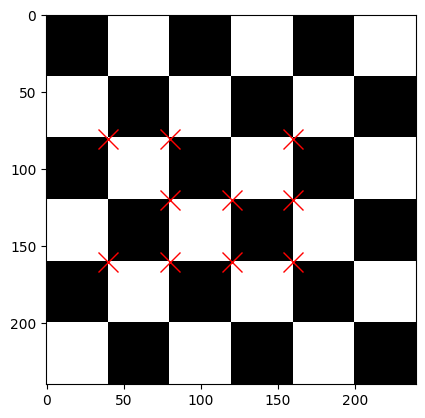

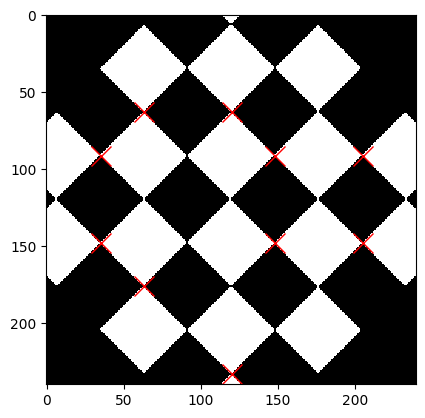

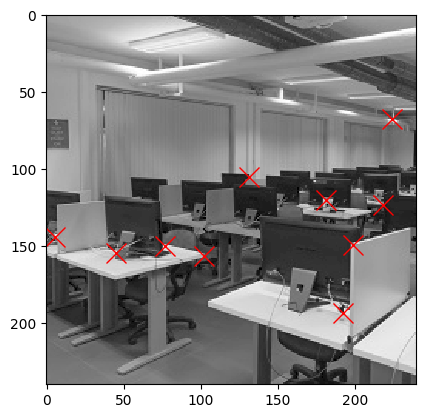

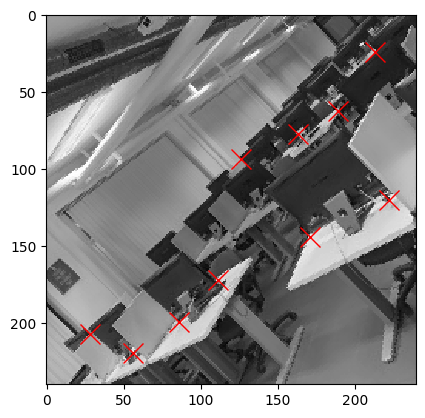

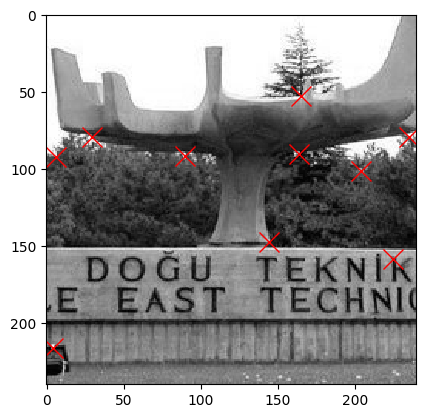

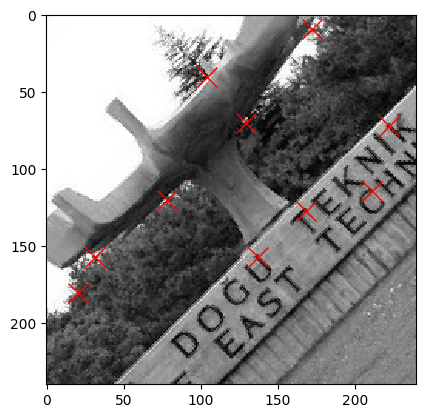

In [8]:
k = 0.05
neighborhood_size = 40
# boundary variable was used to eliminate the artificial high responses originating from image boundaries rather than corners
boundary = 4
window_size = 2
sigma = 1
def fast_harris_gaussian(image, boundary, window_size, sigma):
    # compute Ix, Iy, Ix_squared, Iy_squared, IxIy for the entire image
    Ix = gradient_x(image)
    Iy = gradient_y(image)
    Ix_squared = gaussian_filter(Ix**2, sigma)
    Iy_squared = gaussian_filter(Iy**2, sigma)
    IxIy = gaussian_filter(Ix*Iy, sigma)
    
    height = image.shape[0]
    width = image.shape[1]    

    # coordinates and strength of corners
    corner_strength_coords = []
    corner_strength_values = []

    for y in range(boundary, height-boundary+1):
        for x in range(boundary, width-boundary+1):
            # create windows and calculate Ix^2, Iy^2, IxIy sums
            Ixx_sum = (Ix_squared[y-window_size//2: (y+window_size//2), x-window_size//2: (x+window_size//2)]).sum()
            Iyy_sum = (Iy_squared[y-window_size//2: (y+window_size//2), x-window_size//2: (x+window_size//2)]).sum()
            Ixy_sum = (IxIy[y-window_size//2: (y+window_size//2), x-window_size//2: (x+window_size//2)]).sum()
            
            # calculate corner strength
            determinant = Ixx_sum * Iyy_sum - Ixy_sum * Ixy_sum
            trace = Ixx_sum + Iyy_sum
            corner_strength = determinant - k * (trace**2)
            
            if (corner_strength > 0):
                corner_strength_coords.append([y, x])
                corner_strength_values.append(corner_strength)
                
    return corner_strength_coords, corner_strength_values

images = take_images()
total_time = 0
for image in images:
    start_time = time.time()

    corner_strength_coords, corner_strength_values = fast_harris_gaussian(image, boundary, window_size, sigma)
    max_corners_fast, max_values = non_maximum_suppression(corner_strength_coords, corner_strength_values, image.shape, neighborhood_size)
    max_corners_fast = np.array(max_corners_fast)
    max_values = np.array(max_values)

    # get the top 10 corners' indexes
    top_10_indexes = max_values.argpartition(-10)[-10:]
    # get top_10 corners' coordinates
    top_10_corners = []
    for i in range(len(top_10_indexes)):
        top_10_corners.append(max_corners_fast[top_10_indexes[i]])
    corner_plotter(image, np.array(top_10_corners))

    processing_time = time.time() - start_time  # Time taken to process the image
    total_time += processing_time  # Accumulate the time for each image

print("Average time to process one image:", total_time/len(images) , "seconds")

### Discussion
- The overall runtime is around 5 seconds, slightly increased compared to circular and uniform weighting but still really efficient compared to first three versions.

- The value of k has been selected as 0.05, following the recommendation from the lecture slides, which suggest a range between 0.04 and 0.06.

- We are also effectively capturing corners that are well-distributed across the key interest points in the images. There are some minor differences in the detected points compared to uniform weighting and circular weighting. This may occur due to gaussian weighting provides a smoothing to the image, and weights the central pixels more heavily.

## Fast Implementation + Gaussian Weighting + RGB Split

Average time to process one image: 1.345634937286377 seconds


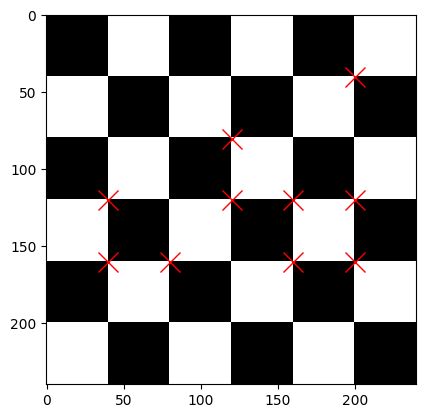

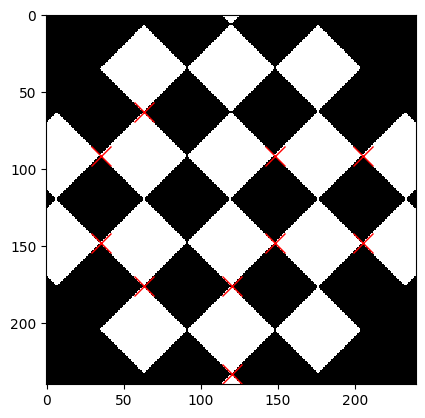

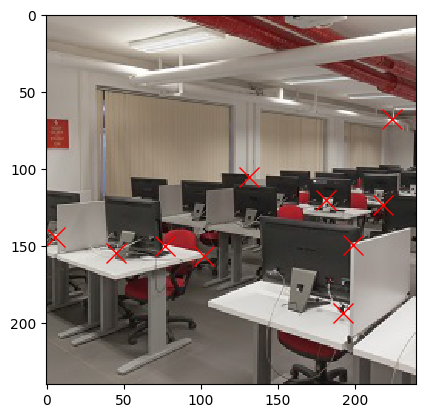

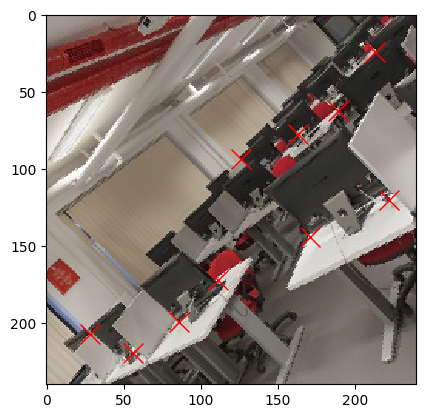

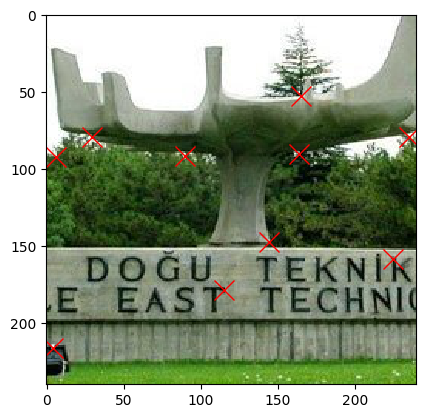

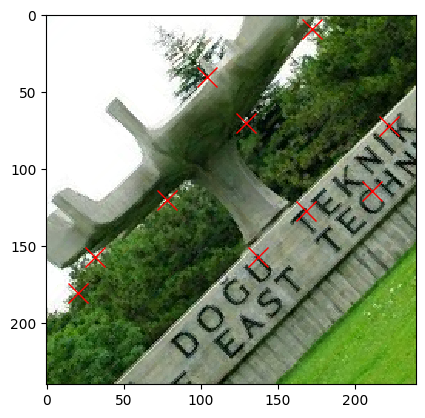

In [9]:
k = 0.05
sigma = 1
neighborhood_size = 40
# boundary variable was used to eliminate the artificial high responses originating from image boundaries rather than corners
boundary = 4
window_size = 2

def fast_harris_channel(image, boundary, window_size, sigma):
    # compute Ix, Iy, Ix^2, Iy^2, IxIy for the entire image
    Ix = gradient_x(image)
    Iy = gradient_y(image)
    Ix_squared = gaussian_filter(Ix**2, sigma)
    Iy_squared = gaussian_filter(Iy**2, sigma)
    IxIy = gaussian_filter(Ix*Iy, sigma)
    
    height, width = image.shape[:2]
    corner_strength = np.zeros((height, width))

    for y in range(boundary, height - boundary):
        for x in range(boundary, width - boundary):
            # create windows and calculate Ix^2, Iy^2, IxIy sums
            Ixx_sum = (Ix_squared[y-window_size//2: y+window_size//2, x-window_size//2: x+window_size//2]).sum()
            Iyy_sum = (Iy_squared[y-window_size//2: y+window_size//2, x-window_size//2: x+window_size//2]).sum()
            Ixy_sum = (IxIy[y-window_size//2: y+window_size//2, x-window_size//2: x+window_size//2]).sum()

            # calculate corner strength
            determinant = Ixx_sum * Iyy_sum - Ixy_sum * Ixy_sum
            trace = Ixx_sum + Iyy_sum
            corner_strength[y, x] = determinant - k * (trace**2)
    
    return corner_strength

def fast_harris_rgb(image, boundary, window_size, sigma=1):
    # Split the image into R,G,B channels
    R, G, B = cv2.split(image)

    # Perform corner detection on each channel seperately
    corner_strength_red = fast_harris_channel(R, boundary, window_size, sigma)
    corner_strength_green = fast_harris_channel(G, boundary, window_size, sigma)
    corner_strength_blue = fast_harris_channel(B, boundary, window_size, sigma)

    # Accumulate corner scores
    total_corner_strength = corner_strength_red + corner_strength_green + corner_strength_blue
    return total_corner_strength

images = take_images_color()
total_time = 0
for image in images:
    start_time = time.time()

    corner_strength = fast_harris_rgb(image, boundary, window_size)
    max_corners, max_values = non_maximum_suppression_rgb(corner_strength, neighborhood_size)
    max_corners = np.array(max_corners)
    max_values = np.array(max_values)

    # get the top 10 corners' indexes
    top_10_indexes = max_values.argpartition(-10)[-10:]
    # get top_10 corners' coordinates
    top_10_corners = []
    for i in range(len(top_10_indexes)):
        top_10_corners.append(max_corners[top_10_indexes[i]])
    corner_plotter(image, np.array(top_10_corners))

    processing_time = time.time() - start_time  # Time taken to process the image
    total_time += processing_time  # Accumulate the time for each image

print("Average time to process one image:", total_time/len(images) , "seconds")


### Discussion

- The overall runtime is around 9 seconds, increased compared to other fast implementation versions. It is due to the fact that in this approach we run corner detection algorithm on RGB color channels seperately and then accumulate the results to obtain corner detection response.  

- The value of k has been selected as 0.05, following the recommendation from the lecture slides, which suggest a range between 0.04 and 0.06.

- We are also effectively capturing corners that are well-distributed across the key interest points in the images. There are some minor differences in the detected points compared to gaussian weighting without RGB split. Applying corner detection to each RGB channel separately may potentially increase the robustness of corner detection, as corners that are consistent across channels are more likely to be true corners.

## Conclusion

In conclusion, among the different approaches we have implemented during THE, the combination of a fast implementation with Gaussian weighting appears to be the most promising approach for corner detection. This method maintains a balance between computational efficiency and the accuracy of detected corners. Gaussian weighting, adds significant value by reducing noise influence and weighting heavily the central pixels in the detection window, which is essential for the accurate localization of corners. The RGB split technique can improve color picture detection by using information from all color channels. However, it also adds computational weight and complexity, which may cause redundant features to be discovered. As a result, the fast implementation using Gaussian weighting demonstrates a high level of accuracy while being computationally efficient.



